In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import h3

In [31]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)
h3_l7_df

,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,warehouse,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
173,872af6375ffffff,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,20
174,872af6acaffffff,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
175,872af6ad9ffffff,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2


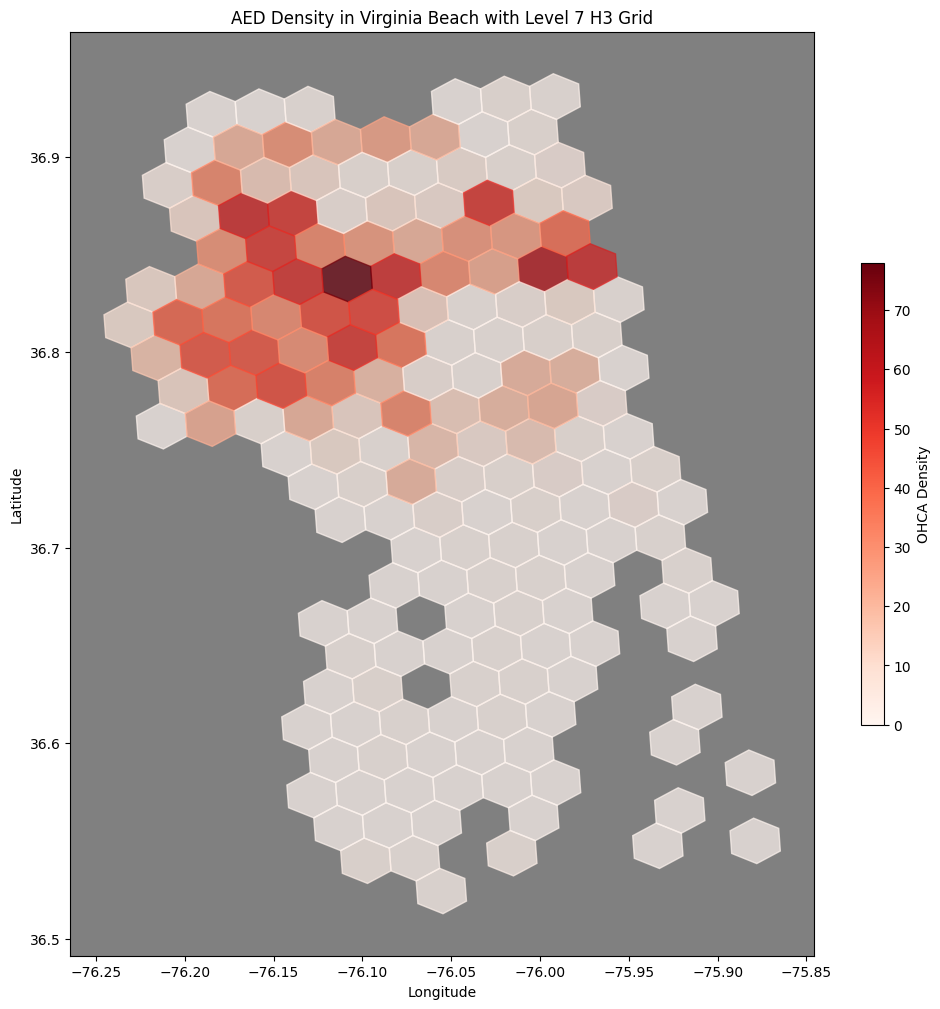

In [32]:
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
import osmnx as ox

districts = ox.geocode_to_gdf([
    'Virginia Beach, Virginia, USA',
])
# Step 3: 繪製行政區背景
fig, ax = plt.subplots(figsize=(12, 12))


# Step 4: 計算各網格內的 AED 密度
density = h3_l7_df[['id', 'ohca']]

# Step 5: 繪製每個網格
for index, row in density.iterrows():
    # 將 H3 索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
    polygon = Polygon(boundary)
    # 根據密度決定顏色
    color_norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
    color = plt.cm.Reds(color_norm(row['ohca']))
    ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)

# Step 6: 創建並顯示顏色條
norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='OHCA Density', shrink=0.5)

# Step 7: 設定地圖的細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('AED Density in Virginia Beach with Level 7 H3 Grid')
ax.set_facecolor('grey')

# 顯示地圖
plt.show()

In [33]:
train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

# XGB

In [61]:
# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=3,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)

# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717
[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17177


[6]	validation_0-rmse:0.16906
[7]	validation_0-rmse:0.16359
[8]	validation_0-rmse:0.15430
[9]	validation_0-rmse:0.14877
[10]	validation_0-rmse:0.14466
[11]	validation_0-rmse:0.14188
[12]	validation_0-rmse:0.14336
[13]	validation_0-rmse:0.14145
[14]	validation_0-rmse:0.13830
[15]	validation_0-rmse:0.13515
[16]	validation_0-rmse:0.13363
[17]	validation_0-rmse:0.13014
[18]	validation_0-rmse:0.12816
[19]	validation_0-rmse:0.12567
[20]	validation_0-rmse:0.12576
[21]	validation_0-rmse:0.12480
[22]	validation_0-rmse:0.12508
[23]	validation_0-rmse:0.12501
[24]	validation_0-rmse:0.12522
[25]	validation_0-rmse:0.12447
[26]	validation_0-rmse:0.12380
[27]	validation_0-rmse:0.12462
[28]	validation_0-rmse:0.12306
[29]	validation_0-rmse:0.12252
[30]	validation_0-rmse:0.12137
[31]	validation_0-rmse:0.12029
[32]	validation_0-rmse:0.12031
[33]	validation_0-rmse:0.12040
[34]	validation_0-rmse:0.12091
[35]	validation_0-rmse:0.12081
[36]	validation_0-rmse:0.12039
[37]	validation_0-rmse:0.12091
[38]	validat

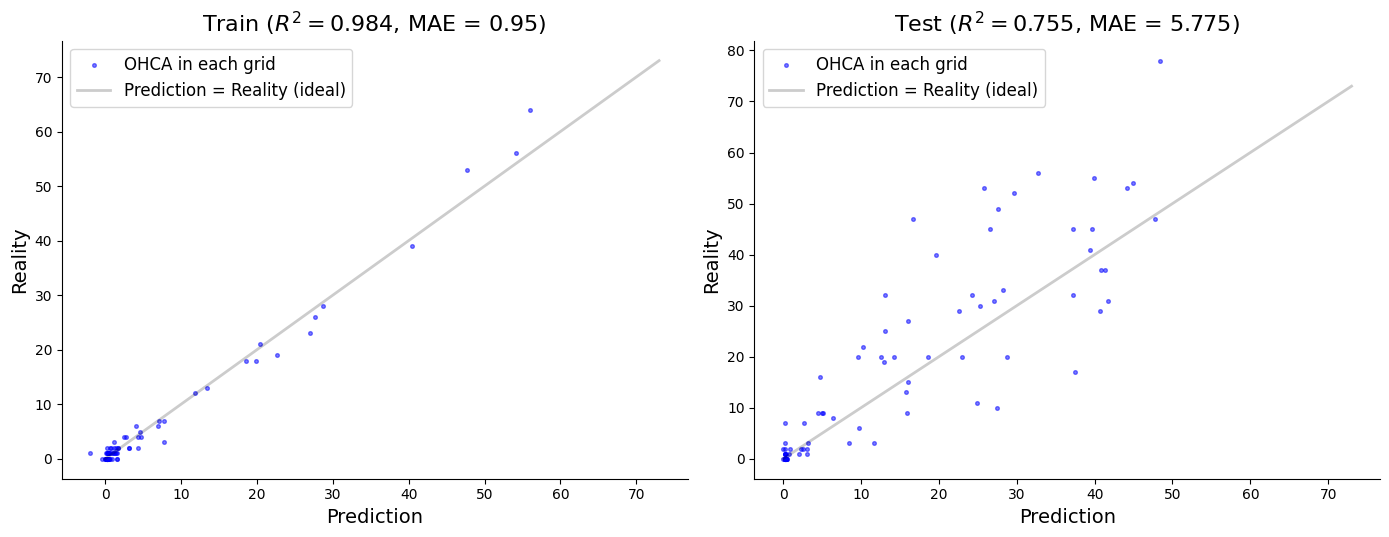

In [35]:
# 建立圖表
fig = plt.figure(figsize=(14, 10))

# 子圖 1：訓練集
ax1 = fig.add_subplot(221)
ax1.scatter(y_head_train, y_train, c="blue", alpha=0.5, label="OHCA in each grid", s=7)
ax1.plot([0, 73], [0, 73], color="black", linewidth=2, label="Prediction = Reality (ideal)", alpha=0.2)
ax1.set_title("Train ($R^2 =$" +str(round(train_r_squared,3)) + ", MAE = " + str(round(train_ans_mae,3)) + ")", fontsize=16)
ax1.set_xlabel("Prediction", fontsize=14)
ax1.set_ylabel("Reality", fontsize=14)
ax1.legend(fontsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# 子圖 2：測試集
ax2 = fig.add_subplot(222)
ax2.scatter(y_head_test, y_test, c="blue", alpha=0.5, label="OHCA in each grid", s=7)
ax2.plot([0, 73], [0, 73], color="black", linewidth=2, label="Prediction = Reality (ideal)", alpha=0.2)
ax2.set_title("Test ($R^2 =$" +str(round(test_r_squared,3)) + ", MAE = " + str(round(test_ans_mae,3)) + ")", fontsize=16)
ax2.set_xlabel("Prediction", fontsize=14)
ax2.set_ylabel("Reality", fontsize=14)
ax2.legend(fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# 調整布局
plt.tight_layout()
plt.show()

# 繪製實驗結果


In [36]:
# 将 y_head_test 添加为新的列
test_h3_l7_df.loc[:, "y_head_test"] = y_head_test

# 检查结果
test_h3_l7_df

C:\Users\Yuan\AppData\Local\Temp\ipykernel_22688\65216883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_h3_l7_df.loc[:, "y_head_test"] = y_head_test


,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca,y_head_test
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.297614
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.297614
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.297614
5,872af0502ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.176647
6,872af0503ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.297614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,872af6370ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,25,13.069896
170,872af6371ffffff,2,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2.320132
171,872af6372ffffff,3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,20,18.626307
172,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3.018849


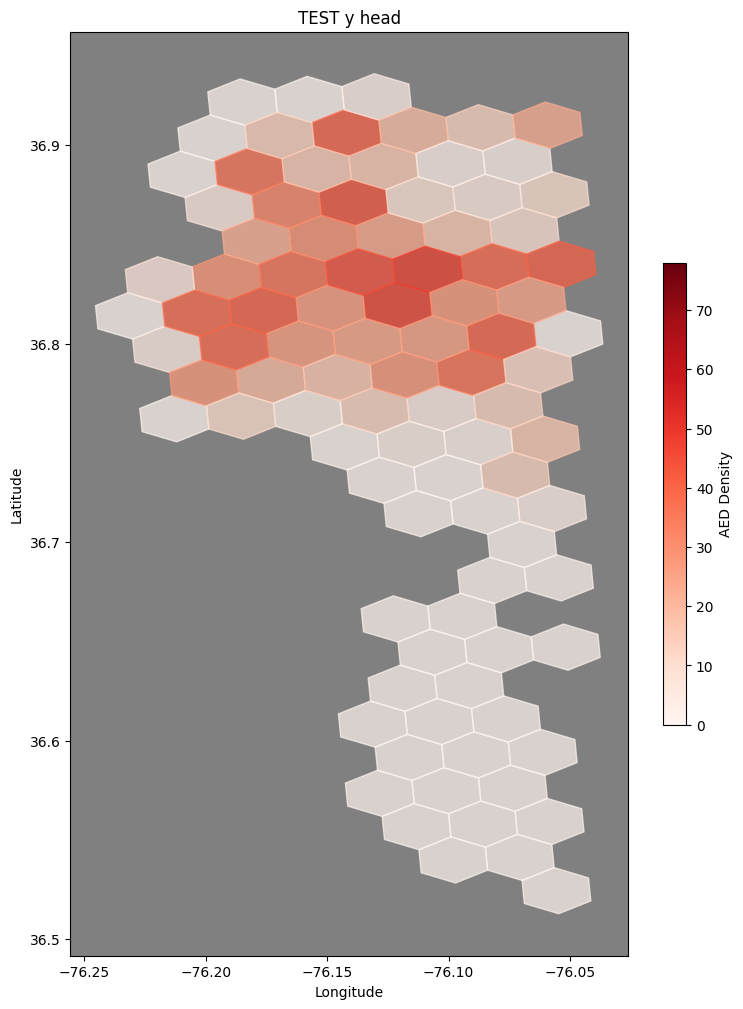

In [37]:
# Step 3: 繪製行政區背景
fig, ax = plt.subplots(figsize=(9, 12))

# Step 4: 計算各網格內的 AED 密度
density_test = test_h3_l7_df[['id', 'y_head_test']]

# Step 5: 繪製每個網格
for index, row in density_test.iterrows():
    # 將 H3 索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
    polygon = Polygon(boundary)
    # 根據密度決定顏色
    color_norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
    color = plt.cm.Reds(color_norm(row['y_head_test']))
    ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)

# Step 6: 創建並顯示顏色條
norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='AED Density', shrink=0.5)

# Step 7: 設定地圖的細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('TEST y head')
ax.set_facecolor('grey')

# 顯示地圖
plt.show()


# fig.savefig('AED_Shenzhen.png')

In [38]:
# 将 y_head_train 添加为新的列
train_h3_l7_df.loc[:, "y_head_train"] = y_head_train

# 检查结果
train_h3_l7_df

C:\Users\Yuan\AppData\Local\Temp\ipykernel_22688\660158301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_h3_l7_df.loc[:, "y_head_train"] = y_head_train


,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca,y_head_train
3,872af0500ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.426305
4,872af0501ffffff,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0.270633
7,872af0504ffffff,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0.126379
8,872af0505ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.483257
9,872af0509ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.297614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,872af636dffffff,4,0,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,56,54.107777
168,872af636effffff,2,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,27.598480
174,872af6acaffffff,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.967696
175,872af6ad9ffffff,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2,1.102085


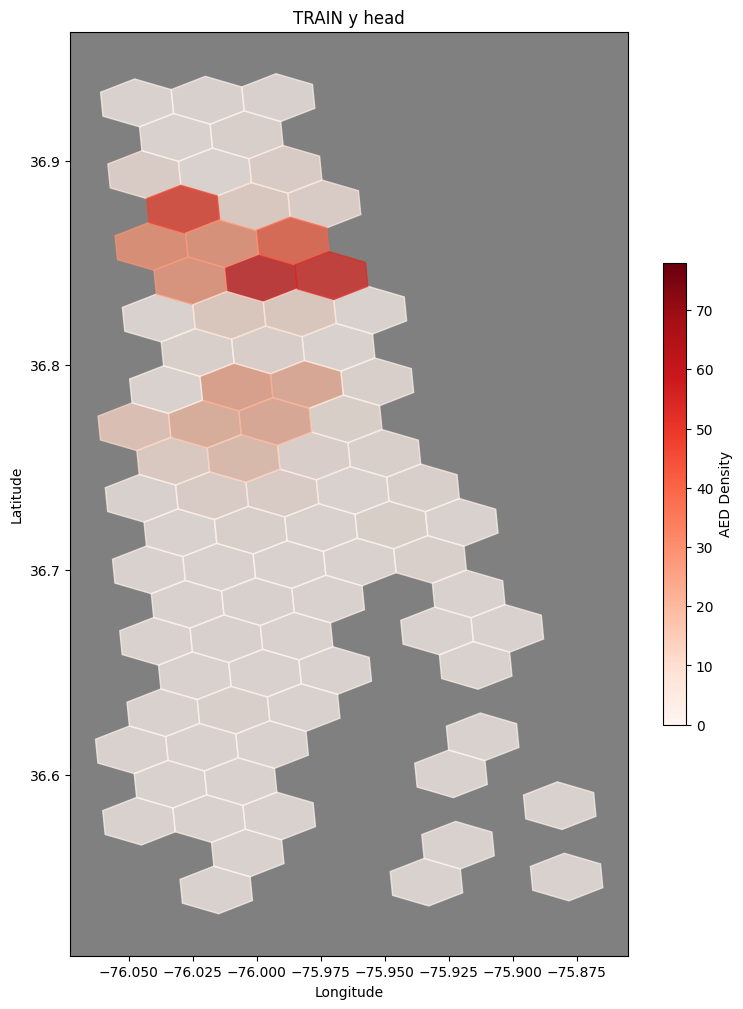

In [39]:
# Step 3: 繪製行政區背景
fig, ax = plt.subplots(figsize=(9, 12))

# Step 4: 計算各網格內的 AED 密度
density_train = train_h3_l7_df[['id', 'y_head_train']]

# Step 5: 繪製每個網格
for index, row in density_train.iterrows():
    # 將 H3 索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
    polygon = Polygon(boundary)
    # 根據密度決定顏色
    color_norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
    color = plt.cm.Reds(color_norm(row['y_head_train']))
    ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)

# Step 6: 創建並顯示顏色條
norm = mcolors.Normalize(vmin=density['ohca'].min(), vmax=density['ohca'].max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='AED Density', shrink=0.5)

# Step 7: 設定地圖的細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('TRAIN y head')
ax.set_facecolor('grey')

# 顯示地圖
plt.show()
